In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline
import pickle
import os

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # recent polynomial coefficients
        self.recent_fit = []

In [3]:
def calibrate_camera():

    # Load in the chessboard calibration images to a list
    cal_image_loc = glob.glob('camera_cal/calibration*.jpg')
    cal_images = []

    # Read in a calibration image
    for fname in cal_image_loc:
        image = mpimg.imread(fname)
        cal_images.append(image)

    # Prepare object points
    nx = 9 # the number of inside corners in x
    ny = 6 # the number of inside corners in y
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays for later storing object points and image points
    objpoints = []
    imgpoints = []

    # Iterate through images for their points
    for image in cal_images:
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(image, (nx, ny), corners, ret)

    # Compute camera calibration matrix and distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # Save the calibration results
    cal_coeffs_pickle = {}
    cal_coeffs_pickle["mtx"] = mtx
    cal_coeffs_pickle["dist"] = dist
    pickle.dump(cal_coeffs_pickle, open("camera_cal_coeffs.p", "wb" ))
    
    return mtx, dist

In [4]:
def thresholding(image, sobel_kernel=3, s_thresh=(0, 255), sx_thresh=(0, 255), r_thresh=(0,255)):

    img = np.copy(image)
    r_channel = img[:,:,0]  #best on white lines
    g_channel = img[:,:,1]    
    b_channel = img[:,:,2]
    
    # Convert to HLS colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]  #best on yellow lines

    # Apply x gradient (derivative) and take the absolute value
    abs_sobelx = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobelx)
    sx_binary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1

    # Threshold S (Saturation) channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold R (Red) color channel
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[((s_binary == 1) & (sx_binary == 1)) | ((sx_binary == 1) & (r_binary == 1))
                     | ((s_binary == 1) & (r_binary == 1))] = 1
    
    return combined_binary

In [5]:
def warp(image, src, dst):
    # Grab the image shape
    image_size = (image.shape[1], image.shape[0])

    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Use cv2.warpPerspective() to warp the image to a top-down view
    top_down = cv2.warpPerspective(image, M, image_size)

    return top_down, M

In [6]:
def detect_lane_pixels(image, margin):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[int(image.shape[0]//2):,:], axis=0)
    plt.figure();
    plt.xlabel('Pixel Position')
    plt.ylabel('Counts')
    plt.title('Histogram of Bottom Half of Threshold/Warped Image')
    plt.plot(histogram, color='b')

    # Create an empty/black output image to draw on and  visualize the result
    out_img = np.dstack((image, image, image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(image.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Plot sliding rectangle windows
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.figure();
    plt.imshow(out_img)
    plt.title('Thresholded/Warped Image with Sliding Windows Drawn')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
        
    return leftx, lefty, rightx, righty

In [7]:
def update_line_class(leftx, lefty, rightx, righty):
    # Fit a second order polynomial to left line
    n = 5
    left_line.current_fit = np.polyfit(lefty, leftx, 2)
    left_line.all_x = leftx
    left_line.all_y = lefty
    left_line.recent_fit.append(left_line.current_fit)
    if len(left_line.recent_fit) > 1:
        left_line.diffs = (left_line.recent_fit[-2] - left_line.recent_fit[-1]) / left_line.recent_fit[-2]
    left_line.recent_fit = left_line.recent_fit[-n:]
    left_line.best_fit = np.mean(left_line.recent_fit, axis = 0)
    left_line.detected = True
    left_fit = left_line.best_fit
    
    # Fit a second order polynomial to right line  
    n = 5
    right_line.current_fit = np.polyfit(righty, rightx, 2)
    right_line.all_x = rightx
    right_line.all_y = righty
    right_line.recent_fit.append(right_line.current_fit)
    if len(right_line.recent_fit) > 1:
        right_line.diffs = (right_line.recent_fit[-2] - right_line.recent_fit[-1]) / right_line.recent_fit[-2]
    right_line.recent_fit = right_line.recent_fit[-n:]
    right_line.best_fit = np.mean(right_line.recent_fit, axis = 0)
    right_line.detected = True
    right_fit = right_line.best_fit
    
    return left_fit, right_fit

In [8]:
def find_lane_boundary(image, margin, left_fit, right_fit):
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + 
                     left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                     (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                     left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + 
                      right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                      (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                      right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Set the x and y values of points on each line
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [9]:
def calc_lane_curvature(ploty, left_fit, right_fit, image_size):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, 'm', right_curverad, 'm')

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.6576/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_line.all_y*ym_per_pix, left_line.all_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_line.all_y*ym_per_pix, right_line.all_x*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad= ((1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
    right_curverad= ((1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
    
    # Compute camera position, assume mounted in center of car
    mid_image = image_size[1] / 2
    car_position = mid_image * xm_per_pix

    # Compute center of the lane
    height_m = image_size[0] * ym_per_pix
    left_line_base = (left_fit_cr[0]*height_m**2)+(left_fit_cr[1]*height_m)+left_fit_cr[2]
    right_line_base = (right_fit_cr[0]*height_m**2)+(right_fit_cr[1]*height_m)+right_fit_cr[2]
    mid_lane = (left_line_base + right_line_base) / 2
    
    # Calculate distance from center and list differently based on left or right
    dist_from_center = mid_lane - car_position
    
    return left_curverad, right_curverad, dist_from_center

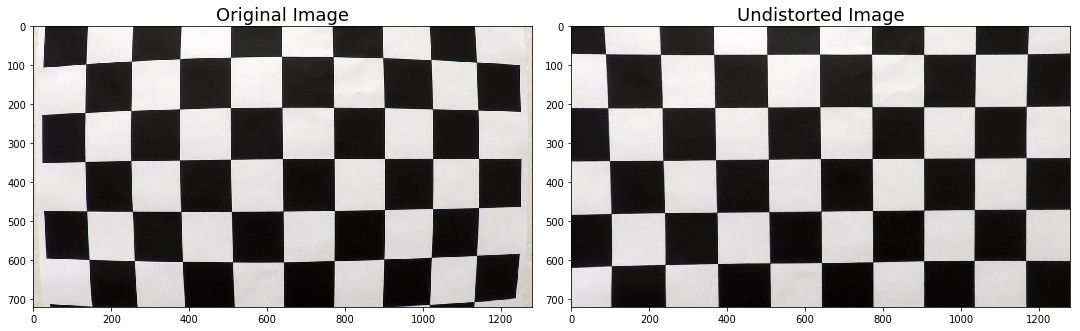

In [10]:
# Read in the saved calibration matrix and distortion coefficients
cal_file = r"./camera_cal_coeffs.p"
if os.path.isfile(cal_file):
    with open(cal_file, mode='rb') as f:
        cal_coeffs_pickle = pickle.load(f)
        mtx = cal_coeffs_pickle["mtx"]
        dist = cal_coeffs_pickle["dist"]
else:
    mtx, dist = calibrate_camera()

# Plot the result
cal_image = mpimg.imread(r"./camera_cal/calibration1.jpg")
undist = cv2.undistort(cal_image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=18)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=18)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
#plt.savefig('output_images/undistorted_cal.jpg')

In [11]:
def process_image(image, plotFlag=False):
    #
    # Apply a distortion correction to raw images
    #
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Plot the result
    if (plotFlag == True):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=18)
        plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)   
        #plt.savefig('output_images/undistorted.jpg')

    # 
    # Apply median blur, color transforms and gradients to create a thresholded binary image
    # 
    ksize = -1 #(scharr filter)
    median = cv2.medianBlur(undist, 3)
    binary_image = thresholding(median, ksize, s_thresh=(120, 255), sx_thresh=(20, 255), r_thresh=(200,255))
    
    # Plot the result
    if (plotFlag == True):
        plt.figure(figsize=(16, 6))
        plt.tight_layout()
        plt.imshow(binary_image, cmap='gray')
        plt.title('Thresholded Image', fontsize=18)
        #plt.savefig('output_images/thresholded.jpg')

    # Source points - defined area of lane line edges
    src = np.float32([[690, 450], 
                      [1110, image.shape[0]], 
                      [175, image.shape[0]], 
                      [595, 450]])
    # Destination points to transform from source points
    offset = 300 # offset for dst points
    dst = np.float32([[image.shape[1]-offset, 0], 
                      [image.shape[1]-offset, image.shape[0]],
                      [offset, image.shape[0]], 
                      [offset, 0]])  
    
    # 
    # Apply a perspective transform to rectify binary image ("birds-eye view")
    # 
    binary_warped, M = warp(binary_image, src, dst)

    # Plot the result
    if (plotFlag == True):
        
        # Better to visualize with straight lines
        image_tmp = mpimg.imread('test_images/straight_lines1.jpg')
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        f.tight_layout()
        pts = np.array(src, np.int32)
        pts = pts.reshape((-1,1,2))
        image_tmp = cv2.polylines(image_tmp, [pts], True, (255,0,0), 2)
        ax1.imshow(image_tmp)
        ax1.set_title('Undistorted Image with Source Points Drawn', fontsize=18)
        out, M2 = warp(image_tmp, src, dst)
        ax2.imshow(out)
        ax2.set_title('Warped Result with Destination Points Drawn', fontsize=18)
        plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)   
        #plt.savefig('output_images/warped_straight_lines.jpg')

    # 
    # Detect lane pixels in image
    # 
    margin = 100 # Set the width of the windows +/- margin
    if left_line.detected == False | right_line.detected == False:
        leftx, lefty, rightx, righty = detect_lane_pixels(binary_warped, margin)
        left_fit, right_fit = update_line_class(leftx, lefty, rightx, righty)

    left_fit = left_line.current_fit
    right_fit = right_line.current_fit

    # 
    # Find the lane boundary with fitting
    # 
    margin = 100 # Set the width of the windows +/- margin
    leftx, lefty, rightx, righty = find_lane_boundary(binary_warped, margin, left_fit, right_fit)
    left_fit, right_fit = update_line_class(leftx, lefty, rightx, righty) 
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Plot the result
    if (plotFlag == True):
        # Create an empty/black output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        plt.figure(figsize=(16, 6));
        plt.imshow(out_img)
        plt.title('Thresholded and Perspective Transform Fit to Polynomial', fontsize=16)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        #plt.savefig('output_images/color_lines_fit.jpg', dpi=100)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        # Create an empty/black output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        window_img = np.zeros_like(out_img)
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure(figsize=(16, 6))
        plt.imshow(result)
        plt.title('Thresholded and Perspective Transform with Lane Lines Fit to Polynomial', fontsize=16)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        #plt.savefig('output_images/color_lanes_fit.jpg', dpi=100)
    
    # 
    # Calculate the pixel curve radius (in meters)
    #
    left_curverad, right_curverad, dist_from_center = calc_lane_curvature(ploty, left_fit, right_fit, image.shape)

    # Calculate distance from center and list differently based on left or right
    if dist_from_center >= 0:
        center_text = "{} meters left of center".format(round(dist_from_center,2))
    else:
        center_text = "{} meters right of center".format(round(-dist_from_center,2))
    
    # List car's position in relation to middle on the image and radius of curvature
    avg_rad = round(np.mean([left_curverad, right_curverad]),0)
    rad_text = "Radius of Curvature = {}(m)".format(avg_rad)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, center_text, (10,50), font, 1,(255,255,255),2)
    cv2.putText(image, rad_text, (10,100), font, 1,(255,255,255),2)

    # Invert the transform matrix from birds eye (to later make the image back to normal below)
    Minv = np.linalg.inv(M)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, new_warp, 0.3, 0)
    
    # Plot the result
    if (plotFlag == True):
        plt.figure(figsize=(16, 6))
        plt.imshow(result)
        plt.title('Original (undistorted) image with lane area drawn', fontsize=16)
        #plt.savefig('output_images/color_lane_area.jpg', dpi=100)

    return result

In [12]:
# For reference only
def moving_avg(N=3):
    mylist = [1, 2, 3, 4, 5, 6, 7]
    N = 3
    cumsum, moving_avgs = [0], []
    for i, x in enumerate(mylist, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_avg = (cumsum[i] - cumsum[i-N])/N
            #can do stuff with moving_ave here
            moving_avgs.append(moving_avg)
    return moving_avgs

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [04:22<00:00,  4.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 5min 54s, sys: 1min 12s, total: 7min 7s
Wall time: 4min 24s


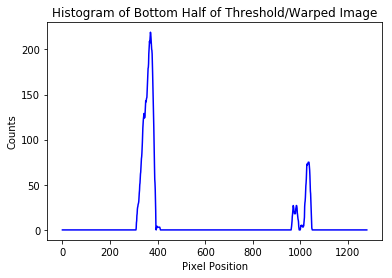

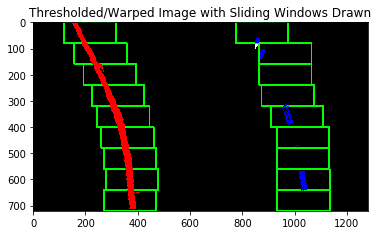

In [13]:
# Class objects for left and right lines
left_line = Line()
right_line = Line()
left_line.detected = False
right_line.detected = False

video_output = 'output_video_test.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip

#clip = VideoFileClip("test_videos/project_video.mp4").subclip(23,24)
clip = VideoFileClip("test_videos/project_video.mp4")
#clip = VideoFileClip("test_videos/challenge_video.mp4")
#clip = VideoFileClip("test_videos/harder_challenge_video.mp4")

video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

array([[[ 47,  53,  75],
        [ 38,  44,  56],
        [ 33,  38,  41],
        ...,
        [ 76,  94,  80],
        [102, 119, 103],
        [145, 159, 142]],

       [[ 40,  45,  64],
        [ 27,  34,  44],
        [ 19,  25,  23],
        ...,
        [  9,  27,  15],
        [ 21,  38,  22],
        [ 90, 104,  89]],

       [[ 35,  41,  53],
        [ 23,  28,  32],
        [ 18,  23,  16],
        ...,
        [ 19,  37,  25],
        [  7,  23,  10],
        [ 14,  28,  13]],

       ...,

       [[ 31,  36,  40],
        [ 51,  50,  55],
        [ 97,  88,  91],
        ...,
        [121, 106, 103],
        [121, 106, 103],
        [124, 109, 106]],

       [[ 42,  47,  51],
        [ 29,  30,  34],
        [ 66,  60,  64],
        ...,
        [130, 115, 112],
        [131, 116, 113],
        [135, 120, 117]],

       [[ 47,  52,  58],
        [ 36,  37,  42],
        [ 37,  31,  35],
        ...,
        [137, 122, 119],
        [138, 123, 120],
        [141, 126, 123]]

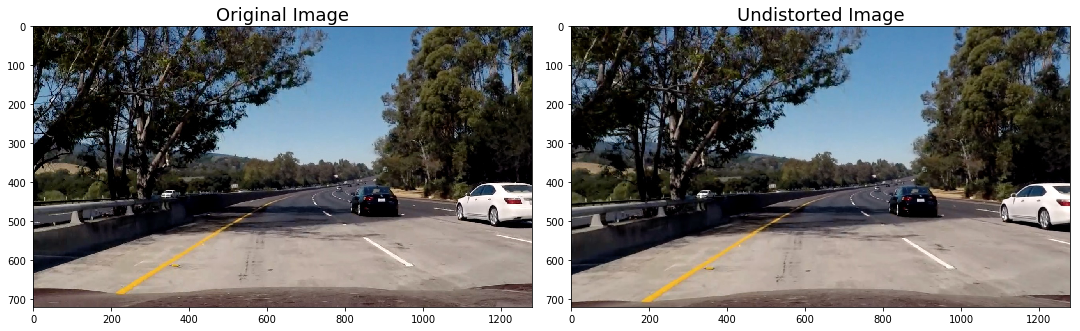

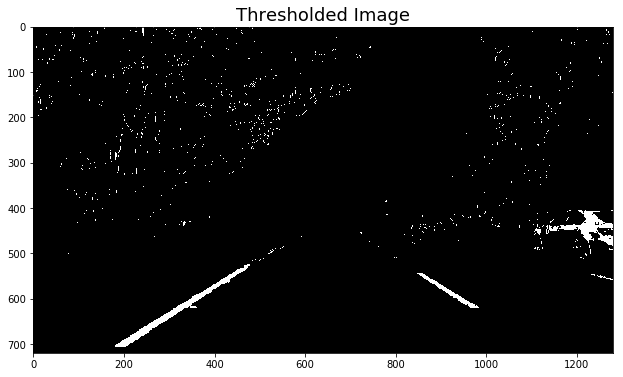

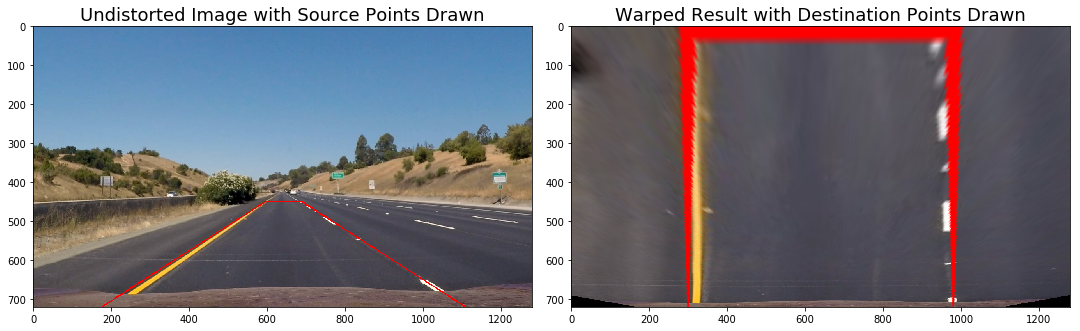

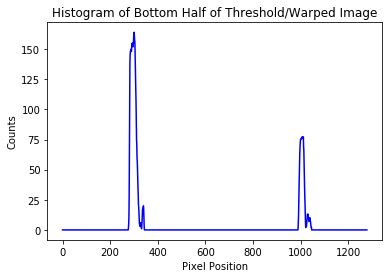

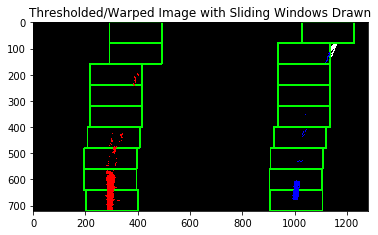

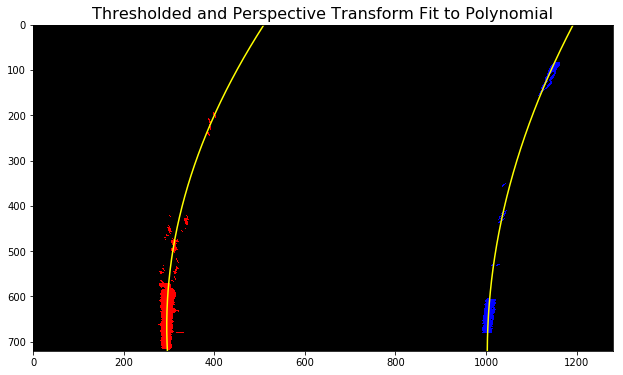

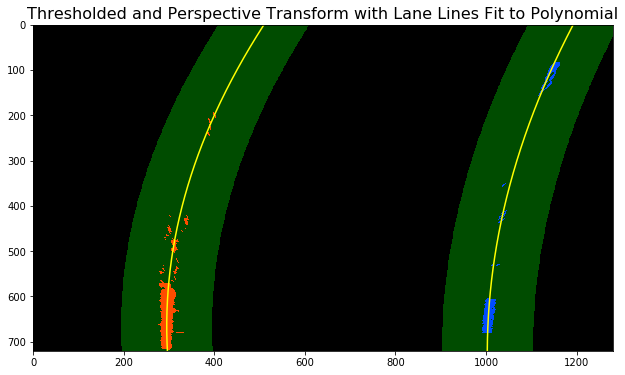

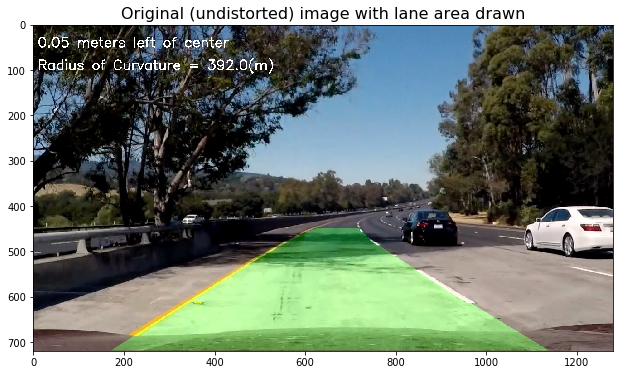

In [14]:
#Unit test driver for single test image
left_line = Line()
right_line = Line()
left_line.detected = False
right_line.detected = False

# Read in an image
image = mpimg.imread('test_images/test5.jpg') #curves, shadows, bridge texture, and cars
process_image(image, plotFlag=True)